## Demo: Data-Driven Decision Modeling using Neural Networks
Authors: Ninyuan Chen, Saman Lagzi, Joseph Milner

IEOR 8100: Contextual Optimization  

Presented by: Mike Qu, 11/1/2024

In [67]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

# np.random.seed(42)

## Generating Synthetic Newsvendor dataset

In [68]:
# Exact implementation of 6.1
num_products = 10
num_stores = 10
num_samples = 25000

# holding and backorder costs
h = 1
b = 10

temperature = np.random.normal(20, 4, num_samples)  # t ~ N(20, 4)
humidity = np.random.uniform(0, 10, num_samples)    # \psi ~ U[0, 10]
day_of_week = np.random.randint(0, 7, num_samples)  # d ~ U{0, ..., 6}
decisions = np.random.uniform(80, 180, num_samples)     # decision (items ordered)

beta_k = np.random.normal(10, 4, num_products)  # \beta_k for store k
beta_j = np.random.normal(10, 4, num_stores)    # \beta_j for product j

def demand_func(t, psi, d, beta_k, beta_j):
    ind_weekend = 1 if d in [5, 6] else 0 
    mu = 100 + (t - 20) + 20 * max(psi - 8, 0) + 5 * ind_weekend + beta_k - beta_j
    return np.random.normal(mu, 16) 

def cost_func(demand, z):
    overstock_cost = h * max(demand - z, 0)
    understock_cost = b * max(z - demand, 0)
    return overstock_cost + understock_cost

# Generate dataset
data = []
for i in range(num_samples):
    # product and store index
    k = np.random.randint(0, num_products)
    j = np.random.randint(0, num_stores)

    # context
    t = temperature[i]
    psi = humidity[i]
    d = day_of_week[i]
    z = decisions[i]

    # demand n cost
    demand = demand_func(t, psi, d, beta_k[k], beta_j[j])
    cost = cost_func(demand, z)
    data.append([t, psi, d, k, j, demand, z, cost])

df = pd.DataFrame(data, columns=["Temperature", "Humidity", "Day", "Product", "Store", "Demand", "Decision", "Cost"])

print(df.shape)

(25000, 8)


In [69]:
df.head()

,Temperature,Humidity,Day,Product,Store,Demand,Decision,Cost
0,24.239878,2.065958,3,1,3,109.560946,100.387969,9.172977
1,18.350212,0.052534,5,1,9,106.977748,138.471076,314.933285
2,16.612813,1.676900,2,0,3,100.006508,162.726704,627.201952
3,26.198372,4.933912,0,8,0,110.377307,110.499672,1.223654
4,16.353598,0.083654,6,1,0,106.593941,176.631894,700.379528


## DONN Model

In [70]:
class DONN(nn.Module):
    def __init__(self, input_size=3, decision_size=1, hidden_size=7, output_size=1):
        super(DONN, self).__init__()
        self.fcx = nn.Linear(input_size, hidden_size)
        self.fcz = nn.Linear(decision_size, hidden_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x, z):
        o = self.act1(self.fcx(x)+self.fcz(z))
        o = self.act2(self.fc2(o))
        o = self.act3(self.fc3(o))
        o = self.fc4(o)
        return o

In [71]:
# Prepare data
X = df[["Temperature", "Humidity", "Day", "Decision"]].values.astype(np.float32)
y = df[["Cost"]].values.astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 200
learning_rate = 1e-7
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in data_loader:
            x_batch = batch[0][:, :3].to(device)  # Extract x (first three entries)
            z_batch = batch[0][:, 3:].to(device)  # Extract z (fourth entry)
            y_batch = batch[1].to(device)  # Target (Cost)
            outputs = model(x_batch, z_batch)
            y_true.append(y_batch)
            y_pred.append(outputs)
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    
    mse = torch.mean((y_true - y_pred) ** 2)
    return mse

# Training function
def train_model(model, train_loader, val_loader, lr, num_epochs, device):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            x_batch = batch[0][:, :3].to(device)  # Extract x (first three entries)
            z_batch = batch[0][:, 3:].to(device)  # Extract z (fourth entry)
            y_batch = batch[1].to(device)  # Target (Cost)
            optimizer.zero_grad()
            outputs = model(x_batch, z_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation step
        val_mse = evaluate_model(model, val_loader, device)
        print(f'Epoch: {epoch+1}/{num_epochs} \t Train MSE: {loss.item()} \t Val MSE: {val_mse.item()}')

# Initialize and train the model
model = DONN(input_size=3, decision_size=1, hidden_size=7, output_size=1).to(device)
train_model(model, train_loader, val_loader, learning_rate, num_epochs, device)

# Evaluate on test set
with torch.no_grad():
    test_mse = evaluate_model(model, test_loader, device)
    print(f'Test MSE: {test_mse.item()}')

cuda
Epoch: 1/50 	 Train MSE: 47606.640625 	 Val MSE: 46895.89453125
Epoch: 2/50 	 Train MSE: 47302.3203125 	 Val MSE: 46276.77734375
Epoch: 3/50 	 Train MSE: 46742.6640625 	 Val MSE: 45560.82421875
Epoch: 4/50 	 Train MSE: 41018.90234375 	 Val MSE: 44791.94921875
Epoch: 5/50 	 Train MSE: 39915.0078125 	 Val MSE: 42711.265625
Epoch: 6/50 	 Train MSE: 31920.2734375 	 Val MSE: 39042.12890625
Epoch: 7/50 	 Train MSE: 34054.94921875 	 Val MSE: 32668.544921875
Epoch: 8/50 	 Train MSE: 26928.984375 	 Val MSE: 29077.197265625
Epoch: 9/50 	 Train MSE: 22345.119140625 	 Val MSE: 29359.443359375
Epoch: 10/50 	 Train MSE: 24301.697265625 	 Val MSE: 28798.900390625
Epoch: 11/50 	 Train MSE: 27249.58984375 	 Val MSE: 28891.025390625
Epoch: 12/50 	 Train MSE: 27626.115234375 	 Val MSE: 27749.67578125
Epoch: 13/50 	 Train MSE: 22681.1640625 	 Val MSE: 27826.298828125
Epoch: 14/50 	 Train MSE: 27484.697265625 	 Val MSE: 27675.904296875
Epoch: 15/50 	 Train MSE: 28398.1640625 	 Val MSE: 27648.439453125

In [72]:
model.eval()

random_sample = df.sample(n=1)
random_sample = random_sample.drop(columns=['Decision','Cost'])
print("Evaluate: how optimal is DONN?\n")
print("Randomly sampling 1 line of data:")
print(random_sample)
x = random_sample[["Temperature", "Humidity", "Day"]].values.astype(np.float32)
x_numpy = np.array(x)[0]
x = torch.tensor(x).to(device).flatten()

b = 10
h = 1

# optimizing true newsvendor cost
print("\nuse scipy.optimize to find the optimal decision using the true newsvendor cost, and the mean demand")
def actual_demand(x):
    temperature, humidity, day = x
    demand = 100 + (temperature - 20) + 20 * max(humidity - 8, 0) + 5 * (day in [5, 6])
    return demand

def actual_cost(z, demand):
    overstock_cost = h * max(demand - z, 0)  # Cost for overstock
    understock_cost = b * max(z - demand, 0)  # Cost for understock
    return overstock_cost + understock_cost

# mathematically find optimal z
def find_optimal_z(x):
    demand = actual_demand(x)

    initial_guess = [demand]
    bounds = [(0, 200)]
    result = opt.minimize(actual_cost, initial_guess, args=(demand,), bounds=bounds)
    
    z_optimal = result.x[0]
    return z_optimal
z_optimal = find_optimal_z(x_numpy)
print(f"The optimal z that minimizes the true newsvendor objective z_opt is: {z_optimal}\n")

# gradient-based optimization 
print("use gradient-based optimization to find the optimal decision in DONN")
for param in model.parameters(): # freeze nn params, make z require grad
    param.requires_grad = False
z = torch.tensor([130.0], requires_grad=True, device=device)  # initial guess for z, 130 because its U[80,180]
optimizer = torch.optim.SGD([z], lr=0.02)  # # gradient-based opt for z

def cost(x, z): # minimize cost, given X and f_{\hat{\theta}}
    cost = model(x, z)
    return cost.mean()

num_steps = 500
for step in range(num_steps):
    optimizer.zero_grad()
    loss = cost(x, z)
    loss.backward()
    optimizer.step()
    if (step+1) % 100 == 0:
        print(f"Step {step+1}, z: {z.item()}, Cost: {loss.item()}")
z_empirical = z.item()
print(f"The optimal z that minimizes the DONN objective z_emp is: {z_empirical}")

d = actual_demand(x)
print("\nWhich decision in (z_opt and z_emp) minimizes the true cost function?")
print(f'true_cost(z_opt) = {actual_cost(z_optimal, d).item()}')
print(f'true_cost(z_donn) = {actual_cost(z_empirical, d).item()}')
print()
print("Which decision in (z_opt and z_emp) minimizes the fitted NN cost function?")
print(f'NN_cost(z_opt) = {cost(x,torch.tensor([z_optimal]).float().to(device)).item()}')
print(f'NN_cost(z_donn) = {cost(x,torch.tensor([z_empirical]).float().to(device)).item()}')

Evaluate: how optimal is DONN?

Randomly sampling 1 line of data:
      Temperature  Humidity  Day  Product  Store      Demand
3561    18.201194  0.085485    1        0      0  120.019517

use scipy.optimize to find the optimal decision using the true newsvendor cost, and the mean demand
The optimal z that minimizes the true newsvendor objective z_opt is: 98.2011947631836

use gradient-based optimization to find the optimal decision in DONN
Step 100, z: 116.65924072265625, Cost: 338.2133483886719
Step 200, z: 103.3184814453125, Cost: 249.2235565185547
Step 300, z: 89.97772216796875, Cost: 160.23385620117188
Step 400, z: 76.636962890625, Cost: 71.24410247802734
Step 500, z: 69.71688079833984, Cost: 42.57210922241211
The optimal z that minimizes the DONN objective z_emp is: 69.71688079833984

Which decision in (z_opt and z_emp) minimizes the true cost function?
true_cost(z_opt) = 0.0
true_cost(z_donn) = 28.48431396484375

Which decision in (z_opt and z_emp) minimizes the fitted NN cost f

In [73]:
model.eval()

devs = []

def symmetric_deviation_percentage(actual, predicted):
    return abs(actual - predicted) / ((abs(actual) + abs(predicted)) / 2) * 100

for _ in range(0,50):
    random_sample = df.sample(n=1)
    x = random_sample[["Temperature", "Humidity", "Day"]].values.astype(np.float32)
    x_numpy = np.array(x)[0]
    x = torch.tensor(x).to(device).flatten()

    z_optimal = find_optimal_z(x_numpy)

    for param in model.parameters(): # freeze nn params, make z require grad
        param.requires_grad = False
    z = torch.tensor([130.0], requires_grad=True, device=device)  # initial guess for z, 130 because its U[80,180]
    optimizer = torch.optim.SGD([z], lr=0.02)  # # gradient-based opt for z
    
    num_steps = 500
    for step in range(num_steps):
        optimizer.zero_grad()
        loss = cost(x, z)
        loss.backward()
        optimizer.step()
    z_empirical = z.item()

    # opts.append(actual_cost(z_optimal, d).item())
    # emps.append(actual_cost(z_empirical, d).item())
    devs.append(symmetric_deviation_percentage(z_optimal, z_empirical))




17.529290785610844


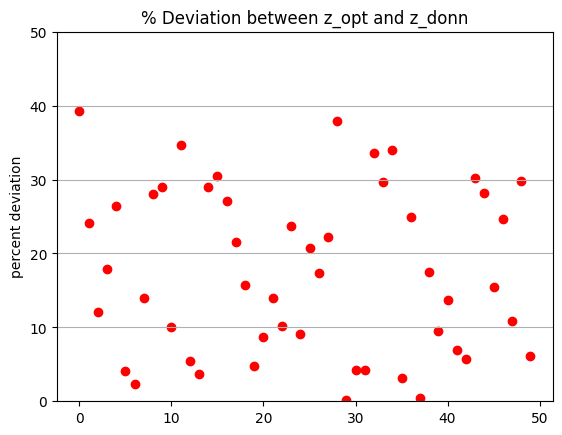

In [74]:
x_axis = range(50)
plt.scatter(x_axis, devs, color='red')
plt.ylim([0,50])
plt.grid(axis="y")
plt.ylabel("percent deviation")
plt.title("% Deviation between z_opt and z_donn")
print(np.mean(devs))